In [1]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import *
from keras.preprocessing import image
from keras.initializers  import glorot_uniform
import tensorflow as tf
import keras.layers.core as Layer  #       
from keras.datasets import cifar10 #
from keras.utils import np_utils #
import math
from keras.callbacks import LearningRateScheduler #
import matplotlib.pyplot as plt




ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [16]:
#GLOBAL ATTENTION BLOCK
def GAB(inputs):
  shape=K.int_shape(inputs)
  x=AveragePooling2D(pool_size=(shape[1],shape[2]))(inputs)
  x=Conv2D(shape[3],1,padding='same')(x)
  x=Activation('relu')(x)
  x=Conv2D(shape[3],1,padding='same')(x)
  x=Activation('sigmoid')(x)
  Fc=Multiply()([x,inputs])

  x=Lambda(lambda x:K.mean(x,axis=-1,keepdims=True))(Fc)
  x=Activation('sigmoid')(x)
  Fc=Multiply()([x,Fc])
  return Fc  

In [17]:
#CATEGORY ATTENTION BLOCK
def CAB(inputs,classes,k):
  shape=K.int_shape(inputs)
  F=Conv2D(k*classes,1,padding='same')(inputs)
  F=BatchNormalization()(F)
  F=Activation('relu')(F)

  Fi=F

  x=GlobalMaxPool2D()(F)
  x=Reshape((classes,k))(x)

  S=Lambda(lambda x:K.mean(x,axis=-1,keepdims=False))(x)
    
  x=Reshape((shape[1],shape[2],classes,k))(Fi)
  x=Lambda(lambda x:K.mean(x,axis=-1,keepdims=False))(x)
  x=Multiply()([S,x])

  ATT=Lambda(lambda x:K.mean(x,axis=-1,keepdims=True))(x)
  Fout=Multiply()([inputs,ATT])
  return Fout


In [5]:
#load cifar10 training and validation set
(X_train,Y_train),(X_valid,Y_valid)=cifar10.load_data()

NameError: name 'cifar10' is not defined

In [4]:
def load_cifar_data(X_train,Y_train,X_valid,Y_valid,rows,cols):

    #resize image data to 224x224(owing to easy implementation and memory constraints some time ,resized to 56 x 56)
    X_train=np.array([cv2.resize(img,(rows,cols))  for img in X_train])
    X_valid=np.array([cv2.resize(img,(rows,cols))  for img in X_valid])
    
    #convert the categories to numberical values
    Y_train=np_utils.to_categorical(Y_train,10)
    Y_valid=np_utils.to_categorical(Y_valid,10)
    
    X_train=X_train.astype('float32') 
    X_valid=X_valid.astype('float32')
    
    #normalize the data
    X_train=X_train/255 
    X_valid=X_valid/255 

    return X_train,Y_train,X_valid,Y_valid

In [1]:
#preprocess data ,convert 32x32 to 224 x 224 (For better Feature Extraction)
X_train,Y_train,X_valid,Y_valid=load_cifar_data(X_train,Y_train,X_valid,Y_valid,224,224)


NameError: name 'load_cifar_data' is not defined

# Identity Module
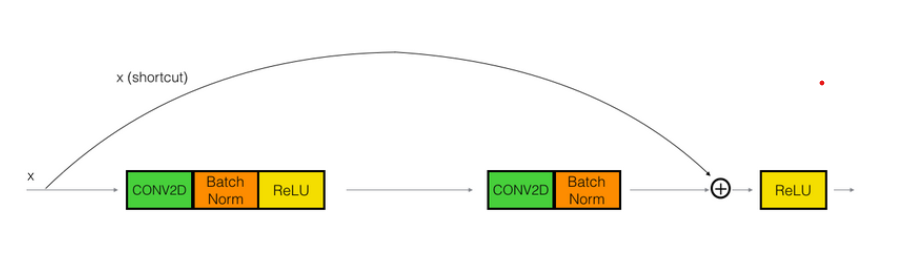

# Convolutional Module
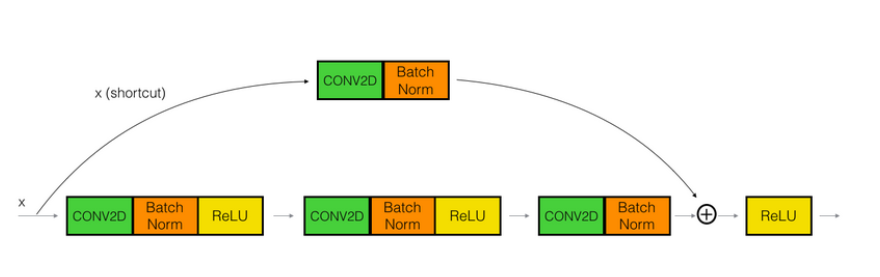

In [13]:
#IDENTITY BLOCK OF RESNET
def Identity_Module(X,f,filters,stage,block):
    
    #to give unique names modules
    conv_name_base='res'+str(stage)+block + '_branch'
    bn_name_base='bn'+str(stage)+block + '_branch'
    
    
    F1,F2,F3 = filters
    
    #Skip Function To Identify Function
    X_Skip=X
     
    
    
    X=Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
    X=Activation('relu')(X)

    X=Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X=Activation('relu')(X)

    X=Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2c')(X)

    X=Add()([X,X_Skip])
    X=Activation('relu')(X)
    
    return X

#CONVOLUTIONAL BLOCK OF RESNET
def Convolutional_Module(X,f,filters,stage,block,s=2):
    
    conv_name_base='res'+str(stage)+block + '_branch'
    bn_name_base='bn'+str(stage)+block + '_branch'
    
    F1,F2,F3 = filters
    
    X_Skip=X
    
    X=Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
    X=Activation('relu')(X)

    X=Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    
    
    X_Skip=Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1_skip', kernel_initializer=glorot_uniform(seed=0))(X_Skip)
    X_Skip=BatchNormalization(axis=3,name=bn_name_base+'1_skip')(X_Skip)
    
    X=Add()([X,X_Skip])
    X=Activation('relu')(X)
    
    return X
    


# RESNET ARCHITECTURE
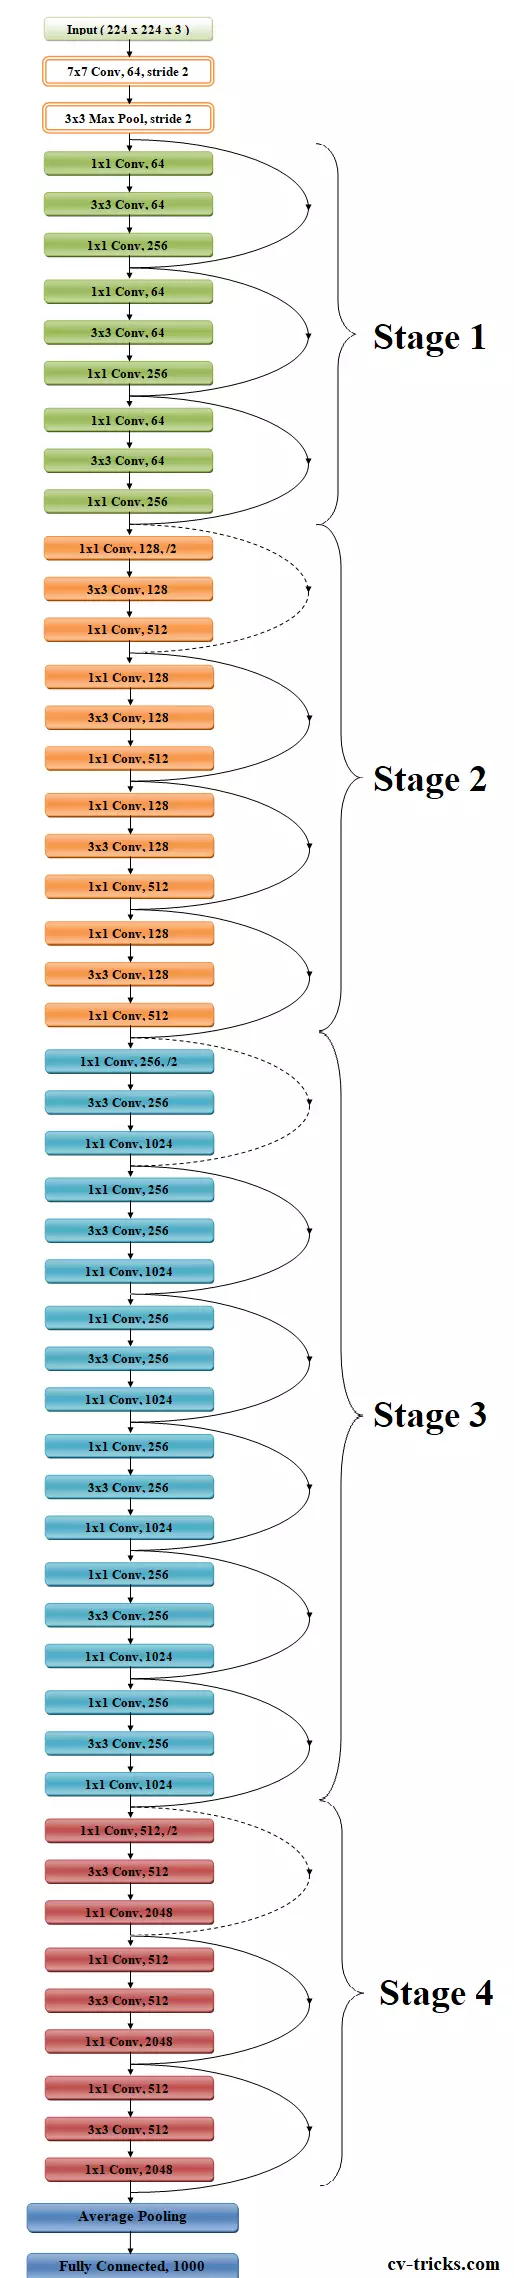

In [14]:
#ResNet50 Implemented as above
def Resnet50(input_shape=(56,56,3)):
    X_Input=Input(shape=input_shape)
    X=GAB(X_Input)
    X=CAB(X,10,10)
    X=ZeroPadding2D((3,3))(X_Input)
    X=Conv2D(64,(7,7),strides=(1,1),name="Convolution_1", kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name="BatchNorm1")(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((3,3),strides=(1,1))(X)
    
    X=Convolutional_Module(X,3,filters=[64,64,256],stage=1,block='a',s=1)
    X=Identity_Module(X,3,filters=[64,64,256],stage=1,block='b')
    X=Identity_Module(X,3,filters=[64,64,256],stage=1,block='c')
    
    X=Convolutional_Module(X,3,filters=[128,128,512],stage=2,block='a',s=2)
    X=Identity_Module(X,3,filters=[128,128,512],stage=2,block='b')
    X=Identity_Module(X,3,filters=[128,128,512],stage=2,block='c')
    X=Identity_Module(X,3,filters=[128,128,512],stage=2,block='d')
    
    X=Convolutional_Module(X,3,filters=[256,256,1024],stage=3,block='a',s=2)
    X=Identity_Module(X,3,filters=[256,256,1024],stage=3,block='b')
    X=Identity_Module(X,3,filters=[256,256,1024],stage=3,block='c')
    X=Identity_Module(X,3,filters=[256,256,1024],stage=3,block='d')
    X=Identity_Module(X,3,filters=[256,256,1024],stage=3,block='e')
    X=Identity_Module(X,3,filters=[256,256,1024],stage=3,block='f')
    
    X=X=Convolutional_Module(X,3,filters=[512,512,2048],stage=4,block='a',s=2)
    X=Identity_Module(X,3,filters=[512,512,2048],stage=4,block='b')
    X=Identity_Module(X,3,filters=[512,512,2048],stage=4,block='c')
    
    X=AveragePooling2D(pool_size=(2,2),padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(10, activation='softmax', name='fc' + str(10), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_Input, outputs=X, name='ResNet50')

    return model
    
    

In [18]:
model=Resnet50(input_shape=(56,56,3))
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 62, 62, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Convolution_1 (Conv2D)          (None, 56, 56, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
BatchNorm1 (BatchNormalization) (None, 56, 56, 64)   256         Convolution_1[0][0]              
___________________________________________________________________________________________

In [19]:
#Compiler Attributes
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)


In [20]:
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history=model.fit(x=X_train,y=Y_train,batch_size=64,epochs=256,callbacks=[lr_sc])
#or fit the model and predict using model.fit


Epoch 1/256

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
126/782 [===>..........................] - ETA: 6:24:59 - loss: 34.8915 - accuracy: 0.1147

In [ ]:
model.predict(X_valid)